# Hydrostatic equilibrum reconstruction

Here we explore the reconstruction of the pressure when in hydrostatic equilibrium

In [1]:
from ppmpy.euler import Euler
from ppmpy.gravity import constant_gravity
from ppmpy.initial_conditions import hse

import matplotlib.pyplot as plt
import numpy as np

HSE atmosphere defaults

In [2]:
params = {"base_density": 1.0, "base_pressure": 1.0, "g_const": -1.0}

## Normal PPM reconstruction

Here we use reflecting boundaries and the standard PPM reconstruction, with limiting.

In [3]:
nx = 16
e = Euler(nx, 0.5, init_cond=hse,
          grav_func=constant_gravity,
          bc_left_type="reflect", bc_right_type="reflect", params=params)

We can look at the reflecting boundary conditions to see what they do to the atmosphere

Text(0.5, 0, 'x')

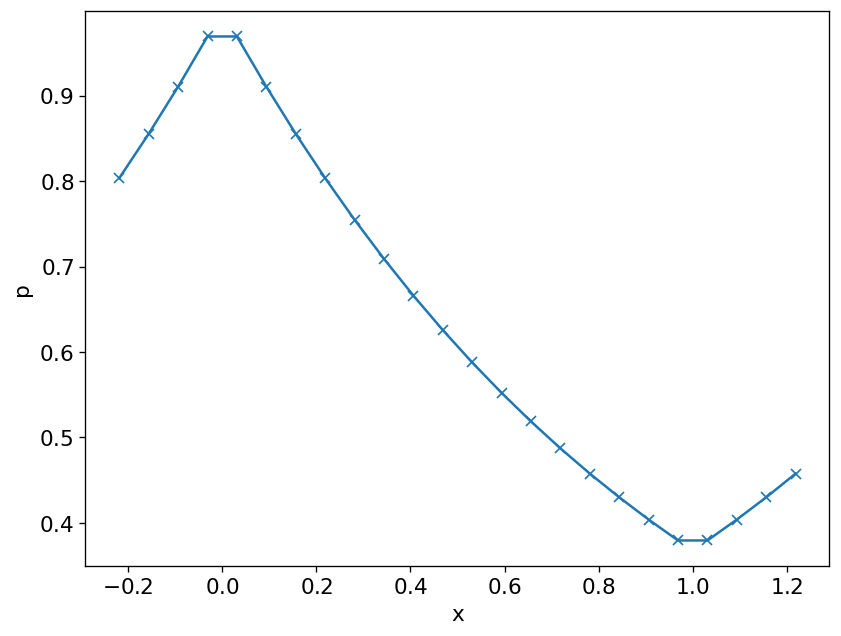

In [4]:
fig, ax = plt.subplots()
q = e.cons_to_prim()
ax.plot(e.grid.x, q[:, e.v.qp], marker="x")
ax.set_ylabel("p")
ax.set_xlabel("x")

Now we can visualize how PPM reconstructs pressure near the lower boundary

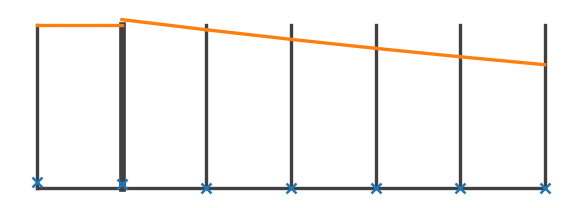

In [9]:
gp = e.grid.draw(lo_index=3, hi_index=8, stretch=2)
e.draw_prim(gp, e.v.qp)

Notice that the first interior zone has a flat profile, so there is no pressure gradient and that zone will not be in HSE
when we use the pressure coming from the Riemann problem to balance the gravitational source term.

## Hydrostatic pressure reconstruction

In [7]:
nx = 16
e = Euler(nx, 0.5, init_cond=hse,
          grav_func=constant_gravity,
          use_hse_reconstruction=True,
          bc_left_type="reflect", bc_right_type="reflect", params=params)

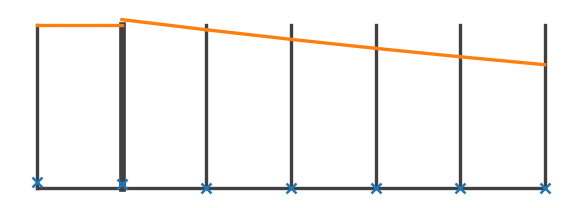

In [8]:
gp2 = e.grid.draw(lo_index=3, hi_index=8, stretch=2)
e.draw_prim(gp2, e.v.qp)

In this case, we see that the pressure in the first interior zone has a gradient that matches the needed HSE pressure gradient.

For the simulations, we will need to reflect the interface states across the boundary so the Riemann solver does not generate a flux through the boundary.